# Welcome to the introduction to machine learning workshop!!!

This is a Python notebook for reference. Feel free to set this up on Google Colab (https://colab.research.google.com/) or your local machine with your favorite IDEs, and follow along with the presentation! 

Once you have the dataset, run the cell below to read in the data and test out all the model demos. The markdown cells will explain what the codes are doing, but please ask questions if anything is unclear, or you run into issues. There are no stupid questions! 

## Categories of ML Tasks

Machine Learning tasks can be generalized into three categories: 
1. Supervised Learning Tasks
    - A model is trained given the input features, X, and their corresponding targets, Y. 
    - EX: regressions tasks, labeled classification tasks
2. Unsupervised Learning Tasks.
    - A model is trained given only the input features, X, without their corresponding targets. 
    - EX: clustering, dimensionality reduction. 
3. Reinforcement Learning Tasks 
    - Train a model or an action policy of an agent based on feedback from the environment. 
    - EX: markov descision process, Q table learning.

In this workshop, we will look at both supervised and unsupervised tasks, including: 
* regression 
    - linear regression 
    - lasso regression 
    - support vector machine 
* classificaiton 
    - logistic regression 
    - decision tree 
    - random forest tree 
* clustering  
    - kmeans clustering
    - density-based spatial clustering of application with noise (DBSCAN)

## Steps to solve a ML task

<h4>We follow the guideline of the `Machine Learning Life Cycle` when building our model.</h4>

<!-- ![ML-Lifecycle](ML-lifecycle.drawio.png){ width="800" height="600" style="display: block; margin: 0 auto" } -->
<p align="center">
    <img src="ML-lifecycle.drawio.png">
<p>

In this workshop, we already collected the data for you, and there will not be any model deployment required. We will focus on model training and evaluation. 
* However, in reality, designing and implementing data pipeline and making model production-ready is a lot more time consuming than model building; we will cover these aspect of ML in other workshops in the future. 

## Tools
* `Pandas`: Read in data and do some basic transformation. 
* `matplotlib`: Visualize model performance. 
* `Scikit-learn (Sklearn)`: A library of ML models and common utility functions. 
* `time`: Native package from Python, it helps us calculate the runtime. 

Here, we use `!pip install <package_name>` to install packages inside of a Jupyter Notebook runtime. Alternatively, you can run `pip install ...` (or `conda install ...` if you have Anaconda available) in your terminal to install these packages in a virtual environment; this way you don't have to run this command every time you launch a new notebook instance. 

In [32]:
# Package download and import
# !pip install scikit-learn

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import time 

In [121]:
# TODO: replace with path to your downloaded dataset  
mobile_price_filepath = './mobile_price_classification_train.csv'
auto_mpg_filepath = './auto-mpg.data'

# load the data into memory
mobile_price_train, mobile_price_test = None, None
mobile_price_df = pd.read_csv(mobile_price_filepath)
auto_mpg_df = pd.read_fwf(auto_mpg_filepath, header=None)
auto_mpg_df = auto_mpg_df.rename(columns={0:'mpg', 1:'cylinders', 2:'displacement', 3:'horsepower', 4:'weight', 5:'acceleration', 6:'year', 7:'origin', 8:'name'})
auto_mpg_df.replace('?', np.NaN, inplace=True)

# Feel free to playaround with this function, but if you change the test_size and/or random_state, you will see different results 
mobile_price_train, mobile_price_test = train_test_split(mobile_price_df, test_size=0.4, random_state=2023, shuffle=True) 
auto_mpg_train, auto_mpg_test = train_test_split(auto_mpg_df, test_size=0.4, random_state=2023, shuffle=True) 

##### Before we being training models, we have to understand what data we are working with.

The `mobile_price` dataset contains mock specifications of 2000 smart phones. In the scripts above, we have split the data into train and test sets, where there are 1200 instance in train set and 600 in test set. <br>

There are a total of 20 feature columns and 1 target columns, and here is `metadata` of the dataset:

| Feature         | Description                                                                       |
| :-------------- | :-------------------------------------------------------------------------------- |
| `battery_power` | int, total energy a battery can store in mAh                                      |
| `blue`          | bool, has bluetooth or not                                                        |
| `clock_speed`   | float, speed at which microprocessor executes instructions                        |
| `dual_sim`      | bool, has dual sim support or not                                                 |
| `fc`            | int, front Camera mega pixels                                                     |
| `four_g`        | bool, has 4G or not                                                               |
| `int_memory`    | int, internal Memory in Gigabytes                                                 |
| `m_dep`         | float, mobile Depth in cm                                                         |
| `mobile_wt`     | int, weight of mobile phone                                                       |
| `n_cores`       | int, number of cores of processor                                                 |
| `pc`            | int, primary Camera mega pixels                                                   |
| `px_height`     | int, pixel Resolution Height                                                      |
| `px_width`      | int, pixel Resolution Width                                                       |
| `ram`           | int, random Access Memory in Megabytes                                            |
| `sc_h`          | int, screen Height of mobile in cm                                                |
| `sc_w`          | int, screen Width of mobile in cm                                                 |
| `talk_time`     | int, longest time that battery will last by a call                                |
| `three_g`       | bool, has 3G or not                                                               |
| `touch_screen`  | bool, has touch screen or not                                                     |
| `wifi`          | bool, has wifi or not                                                             |
| `price_range`   | int; categories of prices: {0: cheap, 1: medium, 2: expensive, 3: very expensive} |

Note: all the `boolean` values are in `integer` form, i.e. 0 and 1. In other cases, if the `boolean` values are `True` and `False`, `sklearn`'s model will automatically interpret them as 0 and 1's.

The `auto-mpg` dataset contains real data from 398 cars. There are a total of 9 features. You can find out more about this dataset at: https://archive.ics.uci.edu/ml/datasets/auto+mpg.

| Feature        | Description                                                                    |
| :------------- | :----------------------------------------------------------------------------- |
| `mpg`          | float, miles per gallon                                                        |
| `cylinders`    | int, number of cylinders in the car's engine                                   |
| `displacement` | float, distance traveled by the piston, determines the volume of fuel consumed |
| `horsepower`   | int, power output of the engine                                                |
| `weight`       | float, weight of the car in Ibs                                                |
| `acceleration` | float, just acceleration                                                       |
| `year`         | int, (last two digits) year of production                                      |
| `origin`       | int, no explanation online, so I have no idea what this is for :(              |
| `name`         | str, name of the car                                                           |


In [122]:
# check out the first entry
mobile_price_train.iloc[:1]

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
729,1135,1,2.8,1,9,0,43,0.4,158,1,...,690,1589,3204,18,13,6,1,0,0,3


In [123]:
auto_mpg_train.iloc[:1]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
159,14.0,8,351.0,148.0,4657.0,13.5,75,1,"""ford ltd"""


## Models

After we have created our train and test sets, we can start working on building different models!

### Supervised Regression 

<b>Our task</b>: use the given a car's horsepower and weight, create a model to predict the car's mpg. 

For supervised regression, we will be looking at three models: 
1. Linear Regression 
2. Linear Regression with L1 Regularization (i.e. Lasso Regression)
3. Support Vector Machine (SVM) for Regression

In [124]:
# separate the features and the target (battery_power)
X_train, y_train = auto_mpg_train[['horsepower', 'weight']].to_numpy(), auto_mpg_train['mpg'].to_numpy()

In [125]:
X_train[:5], y_train[:5]

(array([['148.0', 4657.0],
        ['67.00', 1965.0],
        ['85.00', 2310.0],
        ['150.0', 3436.0],
        ['92.00', 2288.0]], dtype=object),
 array([14., 32., 19., 18., 28.]))

In [126]:
# repeat for the test data 
X_test, y_test = auto_mpg_test[['horsepower', 'weight']].to_numpy(), auto_mpg_test['mpg'].to_numpy()

In [127]:
X_test[:5], y_test[:5]

(array([['93.00', 2391.0],
        ['165.0', 4274.0],
        ['83.00', 2219.0],
        ['80.00', 3230.0],
        ['86.00', 2226.0]], dtype=object),
 array([26. , 13. , 29. , 28.1, 21. ]))

##### Model 1: multivariate linear regression

Linear regression minimizes least square distance between a linear hyperplane to each data points. 
$$ \min_w \sum_{i=1}^N || wx_i - y_i ||^2_2$$
N is the number of training examples. We are finding the set of weights (w) that will minimize the sum of distance.  


In [132]:
# import from linear regression for model, mean squared error for evaluation, and simple imputer to impute missing values (i.e. np.NaN values). 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# impute missing values using the mean value
si = SimpleImputer(missing_values=np.NaN, strategy='mean')
X_train = si.fit_transform(X_train)

# create the model 
lr = LinearRegression(fit_intercept=True, n_jobs=-1) # n_jobs=-1 enables all threads for training 

# train the model 
lr.fit(X_train, y_train)

# make prediction for test set
X_test = si.transform(X_test)
pred = lr.predict(X_test)

# evaluate error 
print("Linear Regression Error (MSE): ", mean_squared_error(y_test, pred), '\n')

Linear Regression Error (MSE):  17.90503504972944 



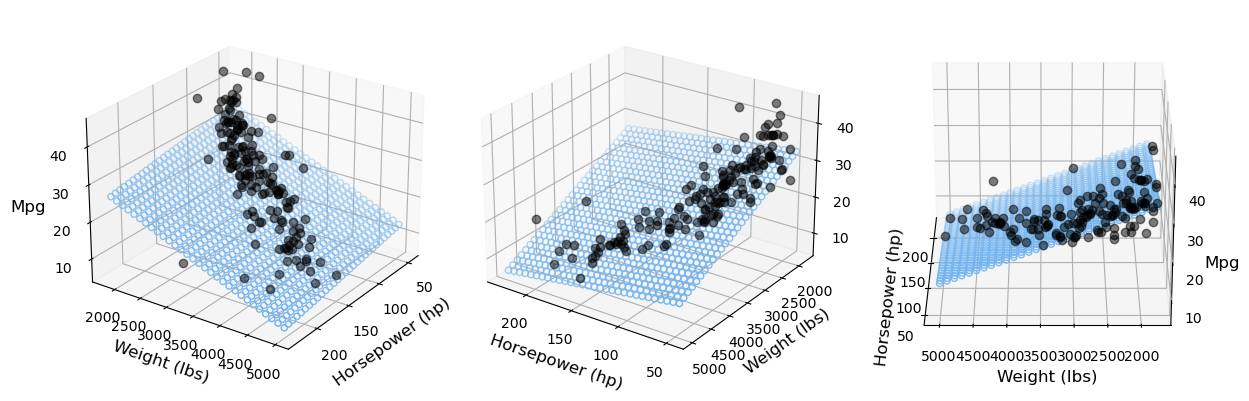

In [143]:
# plot result with hyperplane (don't worry about the code here, but if you are interested: https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html)

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

x, y, z = X_test[:, 0], X_test[:, 1], y_test
xx_pred, yy_pred = np.meshgrid(np.linspace(min(x), max(x), 30), np.linspace(min(y), max(y), 30))
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
prediction = lr.predict(model_viz)

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), prediction, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Horsepower (hp)', fontsize=12)
    ax.set_ylabel('Weight (Ibs)', fontsize=12)
    ax.set_zlabel('Mpg', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.view_init(elev=25, azim=35)
ax2.view_init(elev=25, azim=125)
ax3.view_init(elev=25, azim=180)

fig.tight_layout()

Before we proceed to test our another model, we can we learn from the result of this linear regression model? 
1. Visually, the hyperplane fits to the data pretty well, and the data distribution looks linear. This is a good indicator that using a linear model should perform fairly well on unseen data.
2. Numerically, if we only looked at the MSE, the value is rather high. It is high because the target variable's value, Mpg, ranges from 0 to 50. And 18~ means that there are still a lot of distance between the plane and individual data points. 
    * Back to the plot, we can see that near the edge of the plane, points are further away from our prediction. These points are contributing to our high loss value. 

Now, let's try introducing more features into our linear model and see if this will add more predictive power. 

##### Model 2: Lasso Regression (Linear Regression with Regularization)

Since we are adding more features, let's use a more suitable model. 

Lasso regression still minimizes the least square distance. Different from linear regression, now we are adding a regularization term to the equation we are trying to optimize. 
$$ \min_w \frac{1}{N} \sum_{i=1}^N || wx_i - y_i ||^2_2 + \alpha ||w||_1$$
$\alpha ||w||_1$ is a L1 regularization term. This term enables a form of `feature selection` by turning unimportant feature's weight to 0 during training. 
* This is great when there are a lot of features, and we want to only use the informative features. 

In [147]:
# Use all the non-string features columns 
X_train, y_train = auto_mpg_train.drop(columns=['mpg', 'name']).to_numpy(), auto_mpg_train['mpg'].to_numpy()
X_test, y_test = auto_mpg_test.drop(columns=['mpg', 'name']).to_numpy(), auto_mpg_test['mpg'].to_numpy()
X_train[:1]

array([[8, 351.0, '148.0', 4657.0, 13.5, 75, 1]], dtype=object)

In [152]:
# Train and evaluate the lasso model
from sklearn.linear_model import Lasso

# impute missing values using the mean value
si = SimpleImputer(missing_values=np.NaN, strategy='mean')
X_train = si.fit_transform(X_train)

# create the model 
lasso = Lasso(fit_intercept=True, alpha=0.1) # alpha is the regularization coefficient, it modulates the degree of regularization

# train the model 
lasso.fit(X_train, y_train)

# make prediction for test set
X_test = si.transform(X_test)
pred_lasso = lasso.predict(X_test)

print("Lasso Regression Error (MSE): ", mean_squared_error(y_test, pred_lasso), '\n')

Lasso Regression Error (MSE):  12.38070623528847 



The test error decrease from 18~ to 12~. It is an improvement, but still not significant. 
* Note: because we introduced more than 2 features to our model, we can't visualize the hyperplane in a 3D space anymore. There are other method of visualization that are useful for high dimensional regression problems. If you are interested, read this: https://gagneurlab.github.io/dataviz/high-dimensional-visualizations.html. 

Let's revisit the first 3D plot of our regression plane for a minute. Remember, we noticed some weird behavior at the edge of our plane. Could this means that our real data distribution is not linear? Maybe quadratic or something else? Hmmm...

##### Model 3: Polynomial Regression

Previously, we have been focusing on minimizing the least square distance from each data points to a hyperplane. The mathematical definition for a 3D hyperplane (which takes 2 dimensional features as input) is: $$y(\vec{x}) = w_0 + w_1 x_1 + w_2 x_2$$

In fact, we can increase the degree of our model by apply non-linear basis functions on the input! Essentially, we can make extra terms by combine $x_1$ and $x_2$, such as $x_1 x_2$, $x_1^2$, and $x_2^2$. Now, instead of a hyperplane, we get a paraboloid: $$y(\vec{x}) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1 x_2 + w_4 x_1^2 + w_5 x_2^2$$

The crazy part is that we can still minimize least square distance to find the optimal solution! This means we can still treat this as a linear model. Let's see this in action, shell we? 

In [163]:
# back to using the original two features 
X_train, y_train = auto_mpg_train[['horsepower', 'weight']].to_numpy(), auto_mpg_train['mpg'].to_numpy()
X_test, y_test = auto_mpg_test[['horsepower', 'weight']].to_numpy(), auto_mpg_test['mpg'].to_numpy()

# Train and evaluate the lasso model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline  # Pipeline chains different sklearn modules together, read more: 

# impute missing values using the mean value
si = SimpleImputer(missing_values=np.NaN, strategy='mean')
X_train = si.fit_transform(X_train)

# create the model 
poly_reg = Pipeline([('poly', PolynomialFeatures(degree=2)),  # play around with the degree parameter, I find 2 (i.e. a polynomial function) works the best
                ('linear', LinearRegression(fit_intercept=False))])

# train the model 
poly_reg.fit(X_train, y_train)

# make prediction for test set
X_test = si.transform(X_test)
pred_poly = poly_reg.predict(X_test)

print("Polynomial Regression Error (MSE): ", mean_squared_error(y_test, pred_poly), '\n')

Polynomial Regression Error (MSE):  15.655169372350503 



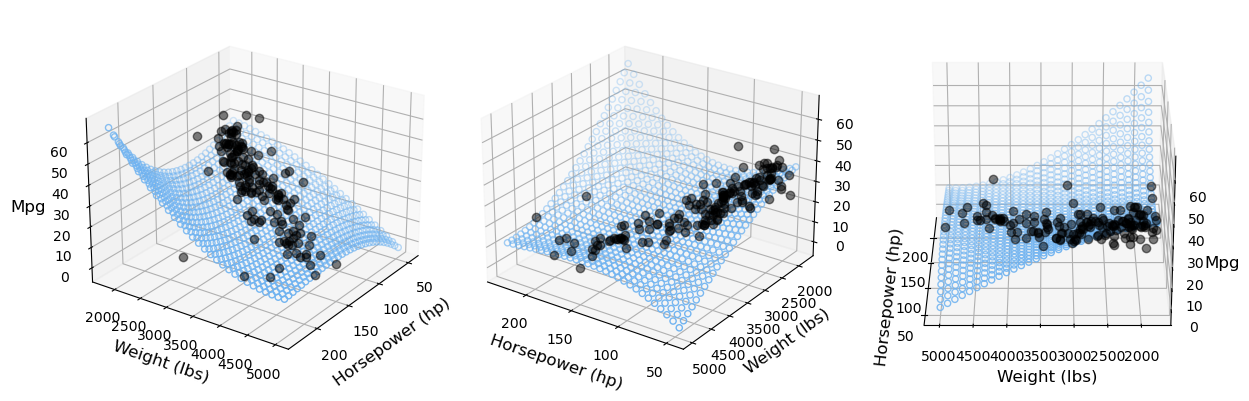

In [162]:
# visualize the result 
plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

x, y, z = X_test[:, 0], X_test[:, 1], y_test
xx_pred, yy_pred = np.meshgrid(np.linspace(min(x), max(x), 30), np.linspace(min(y), max(y), 30))
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
prediction = poly_reg.predict(model_viz)

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), prediction, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Horsepower (hp)', fontsize=12)
    ax.set_ylabel('Weight (Ibs)', fontsize=12)
    ax.set_zlabel('Mpg', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.view_init(elev=25, azim=35)
ax2.view_init(elev=25, azim=125)
ax3.view_init(elev=25, azim=180)

fig.tight_layout()

This didn't work as well as we expected :/ . At least the graph is cool, right?  

To conclude what we did so far: 
* We tested 3 different linear models all minimizes the least square distance. 
* On the auto-mpg dataset, Lasso + more than 2 features, seems to work the best. But, this is 'cheating' because we are using more than 2 features. 
* Using only horsepower and weight, polynomial regression (linear regression + polynomial basis) produced better result than simple linear regression. Although neither lowered the loss to less than 10.

This will be the end of linear models. 

##### Model 4: Support Vector Machine (SVM) 

Before I move on to supervised classification tasks, I want to cover a different class of models, Support Vector Machines. Linear model find a hyperplane by minimizing the distance between every points to the plane, whereas SVMs only cares about the most important points, which are the "support vectors". <br> 

The algorithm is used more for classification rather than regression, but it can be applied to both scenarios.
* For classification, the idea is to find the hyperplane that maximizes the margin between support vectors, while minimize the number of points that are misclassified. 
<p align="center">
    <img src="./SVM.png" width=700>
<p>
* For regression, instead of maximizing the margin between support vectors, we want to include as many points in the margin of error as possible. 
<p align="center">
    <img src="./SVR.png" width=700>
<p>

SVMs are great with high dimensional input, especially when the dimension is greater than the number of samples. We can also choose the kernel function (for now just think of the kernel functions as complicated basis functions), which defines the shape of the decision boundaries. 

In [166]:
from sklearn.svm import SVR 

svr = SVR(kernel='rbf', epsilon=0.01) # refer to the sklearn documentation for what each parameter does: https://scikit-learn.org/stable/modules/svm.html
svr.fit(X_train, y_train)
pred_svr = svr.predict(X_test)
print("SVR MSE: ", mean_squared_error(y_test, pred_svr)) 

SVR MSE:  19.367214686753748


It is not great for regression, but we will revisit SVM for classification. 

### Supervised Classificaiton

For supervised classification, we will be looking at three models: 
1. Logistic Regression
2. Decision Tree 
3. Support Vector Machine (SVM) for Classification

In [ ]:
# Task 4: logistic regression (classification)
from sklearn.linear_model import LogisticRegression

In [ ]:
# Task 5: Decision Tree (Random Forest)
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Task 6: Support Vector Machine 
from sklearn.svm import SVC

### Unsupervised Clustering

For unsupervised clustering, we will be looking at two models: 
1. Kmeans 
2. Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

In [ ]:
# Task 7: Kmeans Clustering 
from sklearn.cluster import KMeans

In [ ]:
# Task 8: DBSCAN 
from sklearn.cluster import DBSCAN 

## Quick Overview of Other Tasks and Use Cases 

##### Resources to look into for your interest!

| Topic            | Link(s)                                                                                     | What for?                                                                                                        |
| :--------------- | :------------------------------------------------------------------------------------------ | :--------------------------------------------------------------------------------------------------------------- |
| Linear Models    | https://scikit-learn.org/stable/modules/linear_model.html                                   | Detail description and code example of sklearn linear models. I only talked about some of them in this workshop. |
| SVM 1            | https://scikit-learn.org/stable/modules/svm.html                                            | Sklearn's documentation on SVM                                                                                   |
| SVM 2            | https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989            | Simple explanation for SVM classification.                                                                       |
| SVM 3            | https://www.youtube.com/watch?v=efR1C6CvhmE&ab_channel=StatQuestwithJoshStarmer             | A video for my fellow non-readers (I never learned how to read and thats okay :) ).                              |
| SVR              | https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2 | Explanation for SVR regression.                                                                                  |
| 3D Plots         | https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html   | Great tutorial on how to impress professor with a fancy 3D plot using matplotlib!                                |
| UCI Data Archive | https://archive.ics.uci.edu/ml/datasets.php                                                 | Massive archive of ready-to-go ML datasets for you personal/academic projects.                                   |
| Markdown Cell    | https://www.markdownguide.org/extended-syntax/                                              | Want to know how I write Latex and Tables in Jupyter Notebook? Look at this.                                     |
